<a href="https://colab.research.google.com/github/abdulSalamKagaji97/data_690_deeplearning/blob/main/DATA690_FINAL_PROJECT_ABDUL_SALAM_KAGAJI_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
from google.colab import drive
import os

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/data_690_deeplearning_project3_dataset/ECG_img_data.zip", 'r')
zip_ref.extractall("/content/")
zip_ref.close()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [40]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
from timeit import default_timer as timer

import torchvision
from torchvision import transforms, datasets, models

import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F

from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d
from torch.nn import Module, Softmax, BatchNorm2d, Dropout

import gc

import os
from os import walk
import glob

import cv2

from IPython.core.interactiveshell import InteractiveShell
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
InteractiveShell.ast_node_interactivity = 'all'

In [5]:
data_path = "/content/ECG_Image_data"
print(os.listdir(data_path))

['train', 'test']


In [6]:

def list_files(startpath):
    
    for root, dirs, files in os.walk(startpath):
        
        level = root.replace(startpath, '').count(os.sep)
        
        indent = ' ' * 4 * (level)
        
        print('{}{}'.format(indent, os.path.basename(root)), '-', len(os.listdir(root)))
        
folder = data_path
list_files(folder)

ECG_Image_data - 2
    train - 6
        M - 8405
        Q - 6431
        F - 642
        S - 2223
        N - 75709
        V - 5789
    test - 6
        M - 2101
        Q - 1608
        F - 161
        S - 556
        N - 18926
        V - 1447


In [7]:
classes = ('S', 'V', 'Q', 'N', 'F')

In [41]:
# Define default PATH

TRAIN_PATH        = data_path+'/train'

transform         = transforms.Compose(
                                       [transforms.Resize([120,120]),
                                        transforms.Grayscale(), 
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5), (0.5))
                                       ])
  
train_data_set    = datasets.ImageFolder(root=TRAIN_PATH, transform=transform)

batch_size=64

train_data_loader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True)

In [42]:
TEST_PATH        = data_path+'/test'
  
test_data_set    = datasets.ImageFolder(root=TEST_PATH, transform=transform)

test_data_loader = DataLoader(test_data_set, batch_size=batch_size, shuffle=True)

In [43]:
# Run this to test your data loader

images, labels = next(iter(train_data_loader))

In [44]:
print(type(images))

print(images.size())

print("")
print("Batch Size:   ",images.size()[0])
print("Channel Size: ",images.size()[1])
print("Image Height: ",images.size()[2])
print("Image Width:  ",images.size()[3])

<class 'torch.Tensor'>
torch.Size([300, 1, 120, 120])

Batch Size:    300
Channel Size:  1
Image Height:  120
Image Width:   120


In [45]:
def imshow_tensor(image, ax=None, title=None, normalize=True):
    
    """Imshow for Tensor."""
    
    if ax is None:
        fig, ax = plt.subplots()
        
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.5])
        std = np.array([0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

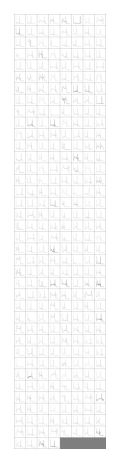

In [46]:
# show images

ncol = 8;

imshow_tensor(torchvision.utils.make_grid(images,nrow = ncol));

In [47]:
# print labels

classes = ('N', 'Q', 'F', 'S', 'V')

nrow = batch_size/ncol;

for row in range(int(nrow)):
    print(' '.join('%5s' % classes[labels[(row*ncol)+j]-1] for j in range(ncol))) 

    Q     Q     Q     Q     S     N     F     Q
    N     Q     Q     Q     Q     Q     Q     F
    Q     V     F     Q     Q     Q     Q     Q
    F     Q     N     F     Q     Q     Q     Q
    Q     Q     Q     Q     Q     Q     Q     Q
    S     Q     S     F     Q     Q     Q     F
    V     Q     Q     Q     V     N     N     Q
    Q     Q     F     Q     N     Q     Q     N
    Q     Q     Q     Q     Q     Q     Q     Q
    Q     N     Q     N     F     Q     Q     Q
    F     Q     Q     Q     Q     Q     Q     Q
    Q     Q     Q     Q     V     Q     Q     S
    Q     Q     Q     Q     Q     N     Q     Q
    V     Q     F     Q     Q     Q     F     Q
    Q     Q     Q     Q     Q     Q     Q     S
    Q     Q     Q     Q     F     Q     Q     Q
    Q     Q     Q     N     Q     Q     F     Q
    Q     Q     Q     Q     Q     Q     Q     Q
    V     Q     Q     Q     Q     Q     Q     Q
    Q     Q     Q     Q     Q     Q     Q     F
    Q     Q     Q     N     V     Q     

In [48]:
# CNN Architect

class ConvNet_1(nn.Module):
    
    def __init__(self):
        
        super(ConvNet_1, self).__init__()

        self.layer_1  = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1)
        
        self.relu1    = nn.ReLU(inplace=True)
        
        self.maxpool1 = MaxPool2d(kernel_size=2)
        

        self.layer_2  = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, stride=1, padding=1)
        
        self.relu2    = nn.ReLU(inplace=True)
        
        self.maxpool2 = MaxPool2d(kernel_size=2)
        
        self.drop_out = nn.Dropout()
        
        
        # out_channels = 4, number of classes = 5
        
        # image width = 120, image height = 120 after two maxpooling 120 -> 60 -> 30
        
        self.fc1 = nn.Linear(4 * 30 * 30, 5)
        
    # Defining the forward pass

    def forward(self, x):
        
        out = self.layer_1(x)
        
        out = self.relu1(out)
        
        out = self.maxpool1(out)
        
        
        out = self.layer_2(out)
        
        out = self.relu2(out)
        
        out = self.maxpool2(out)
        
        
        out = out.reshape(out.size(0), -1)
        
        out = self.drop_out(out)
        
        out = self.fc1(out)
        
        return out
    
# Define Model

model_1 = ConvNet_1()

print(model_1)

ConvNet_1(
  (layer_1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU(inplace=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer_2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU(inplace=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3600, out_features=5, bias=True)
)


In [49]:
# Define Criterion

criterion = nn.CrossEntropyLoss()

# Define Optimizer

optimizer = optim.SGD(model_1.parameters(), lr=0.001, momentum=0.9)

In [50]:
# Whether to train on a gpu and Number of gpus

if cuda.is_available(): 
    
    print(f'{cuda.device_count()} number of gpus are detected and available.')
    
else:
        
    print(f'Train on gpu is not available')
        
        

1 number of gpus are detected and available.


cuda
Epoch [1/1], Step [300/331], Loss: 0.8496, Accuracy: 75.00%
tensor([[75572,  6412,  2218,  5779,  9016],
        [   45,     9,     2,     3,     7],
        [   14,     1,     2,     0,     4],
        [   48,     6,     1,     2,    10],
        [   30,     3,     0,     5,    10]], device='cuda:0',
       dtype=torch.int32)
class name: N, total number of class: 75709, Correctly predicted: 75572, Recall: 1.00%, Precision: 0.76%, F1-Score: 0.87%
class name: Q, total number of class:  6431, Correctly predicted:     9, Recall: 0.00%, Precision: 0.14%, F1-Score: 0.00%
class name: S, total number of class:  2223, Correctly predicted:     2, Recall: 0.00%, Precision: 0.10%, F1-Score: 0.00%
class name: V, total number of class:  5789, Correctly predicted:     2, Recall: 0.00%, Precision: 0.03%, F1-Score: 0.00%
class name: F, total number of class:  9047, Correctly predicted:    10, Recall: 0.00%, Precision: 0.21%, F1-Score: 0.00%
Finished Training


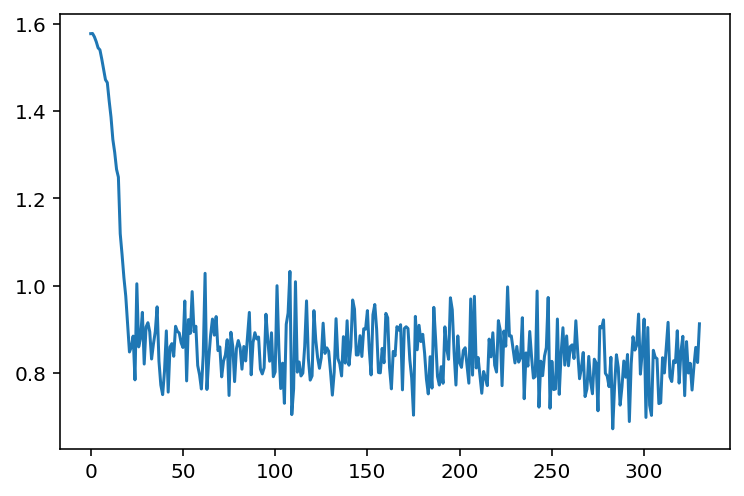

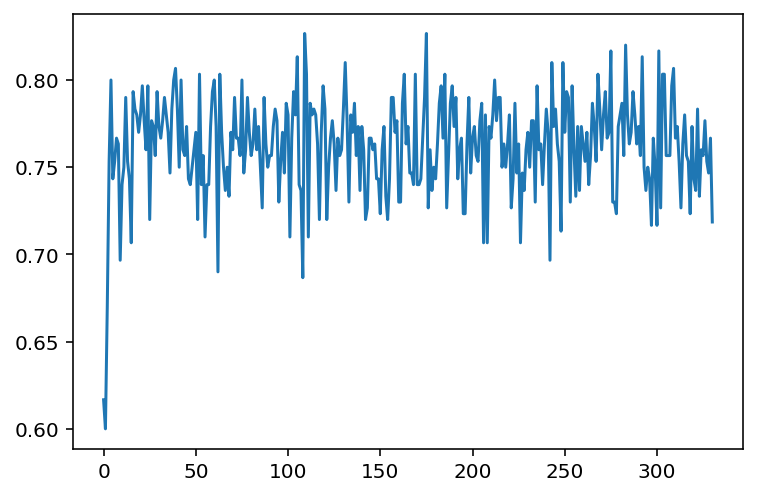

In [51]:
# This part is working

if torch.cuda.is_available():
    
    MODEL = model_1.cuda()
    CRITERION = criterion.cuda()
    print("cuda")
    
else:
    
    MODEL = model_1
    CRITERION = criterion
    print("cpu")

# Train the model

total_step = len(train_data_loader)
loss_list = []
acc_list = []

num_epochs = 1

class_list = ['N', 'Q', 'S', 'V', 'F']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

all_con_mat = torch.zeros([num_epochs, 5, 5], dtype=torch.int32, device=device)

for epoch in range(num_epochs):
    
    f1_score_list=[0,0,0,0,0]

    precision_list=[0,0,0,0,0]

    recall_list=[0,0,0,0,0]
    
    delta = 0.0000000000001 
    
    # define empty tensor 5*5 beginning of every epoch
    # tensor [row,column]
    con_mat = torch.zeros([5, 5], dtype=torch.int32, device=device)
    
    for i, data in enumerate(train_data_loader):
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # optimization
        optimizer.zero_grad()
        
        # Forward to get output
        outputs = MODEL(inputs)
        # Calculate Loss
        #  print(outputs.size())
        # print(labels)
        labels = [x.item()-1 if x > 0 else x for x in labels]
        # print(labels)
        labels = torch.tensor(labels)
        labels =  labels.to(device)
        # print(labels)
        loss = CRITERION(outputs, labels)
        # Backward propagation
        loss.backward()
        # Updating parameters
        optimizer.step()
        
        # Store loss
        loss_list.append(loss.item())
    
        # Calculate labels size
        total = labels.size(0)
        
        # Outputs.data has dimension batch size * 5
        # torch.max returns the max value of elements(_) and their indices(predicted) in the tensor array
        _, predicted = torch.max(outputs.data, 1)
        
        # Calculate total number of correct labels 
        correct = (predicted == labels).sum().item()
        
        # Store accuracy
        acc_list.append(correct / total)
        
        for element in range(total):
            
            # con_mat[row,column]
            # con_mat[predictions, actual]
            con_mat[predicted[element].item()-1][labels[element].item()-1] += 1

        if (i + 1) % 300 == 0:                             # every 300 mini-batches...
            
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))
    print(con_mat)
            
    all_con_mat[epoch] = con_mat
    
    # Print Confusion Matrix
    
    for i in range(torch.sum(con_mat, dim=0).size(0)): 
    
        recall_list[i] = con_mat[i][i].item()/(torch.sum(con_mat, dim=0)[i].item()+delta)
    
        precision_list[i] = con_mat[i][i].item()/(torch.sum(con_mat, dim=1)[i].item()+delta)
    
        f1_score_list[i] = 2 * precision_list[i]*recall_list[i]/(precision_list[i]+recall_list[i]+delta)
        
    
        print('class name: {}, total number of class: {:>5}, Correctly predicted: {:>5}, Recall: {:.2f}%, Precision: {:.2f}%, F1-Score: {:.2f}%'
          
                  .format(class_list[i],
                          torch.sum(con_mat, dim=0)[i].item(),
                          con_mat[i][i].item(), 
                          recall_list[i],
                          precision_list[i],
                          f1_score_list[i]
                         ))
    
            
print('Finished Training')

plt.plot(loss_list);
plt.show();

plt.plot(acc_list);
plt.show();

In [ ]:
confusion_mat = torch.zeros([5, 5], dtype=torch.int32, device=device)

with torch.no_grad():
    
    for data in test_data_loader:
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        labels = [x.item()-1 if x > 0 else x for x in labels]
        # print(labels)
        labels = torch.tensor(labels)
        labels =  labels.to(device)
        
        outputs = MODEL(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total = labels.size(0)
        
        # Calculate total number of correct labels 
        correct = (predicted == labels).sum().item()
        
        for element in range(total):
            
            # confusion_mat[row,column]
            # confusion_mat[predictions, actual]
            confusion_mat[predicted[element].item()-1][labels[element].item()-1] += 1

    print(confusion_mat)

In [32]:
from sklearn.metrics import confusion_matrix

,0,1,2,3,4
0,18912,3,3,7,0
1,3,1605,0,0,0
2,0,0,386,13,1
3,11,0,156,1425,13
4,0,0,11,2,2248


<Figure size 864x504 with 0 Axes>

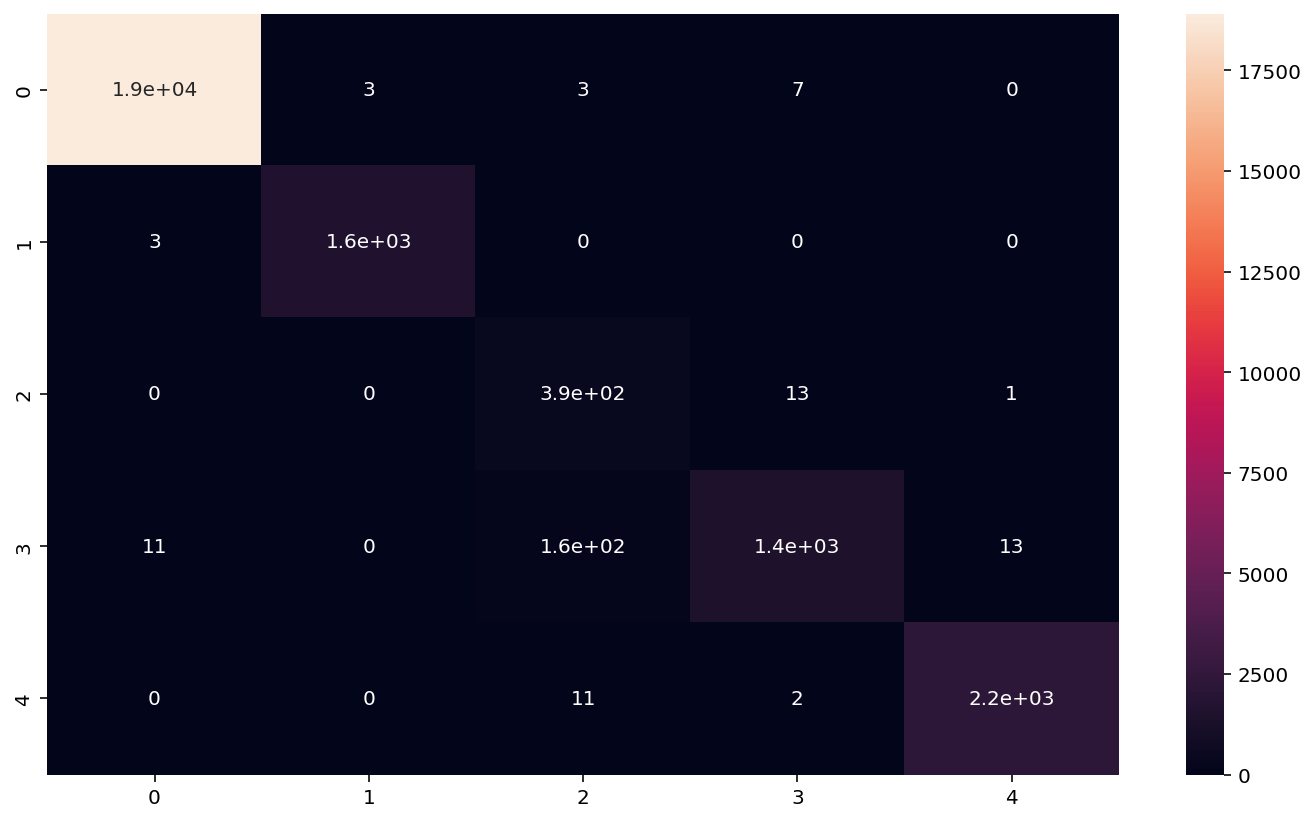

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
df_cm = pd.DataFrame(confusion_mat.cpu().numpy())
display(df_cm)
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.savefig('output.png')